In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(
    "data.csv",
    encoding="latin1",
    usecols=["no2"],
    low_memory=False
)

x = pd.to_numeric(df["no2"], errors="coerce").dropna().values


In [24]:
r = 102303931

a = 0.5 * (r % 7)
b = 0.3 * ((r % 5) + 1)

z = x + a * np.sin(b * x)


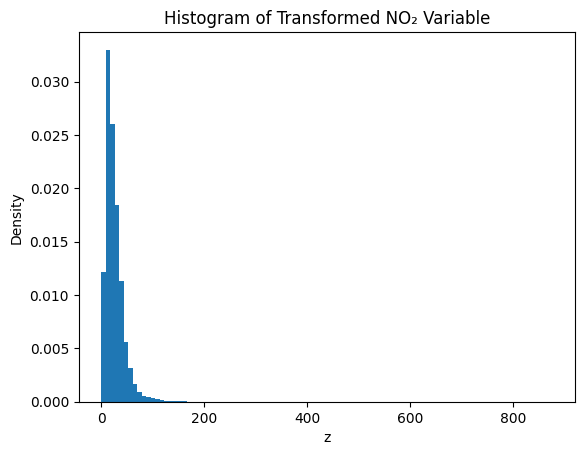

In [25]:
plt.hist(z, bins=100, density=True)
plt.xlabel("z")
plt.ylabel("Density")
plt.title("Histogram of Transformed NO₂ Variable")
plt.show()


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

z_real = torch.tensor(z, dtype=torch.float32).view(-1, 1).to(device)


In [27]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, noise):
        return self.net(noise)


In [28]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [29]:
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(G.parameters(), lr=0.0005)
optimizer_D = optim.Adam(D.parameters(), lr=0.0005)


In [30]:
epochs = 15000
batch_size = 64

for epoch in range(epochs):
    idx = torch.randint(0, z_real.size(0), (batch_size,))
    real_samples = z_real[idx]

    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    noise = torch.randn(batch_size, 1).to(device)
    fake_samples = G(noise)

    loss_D = criterion(D(real_samples), real_labels) + \
             criterion(D(fake_samples.detach()), fake_labels)

    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

    noise = torch.randn(batch_size, 1).to(device)
    fake_samples = G(noise)

    loss_G = criterion(D(fake_samples), real_labels)

    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, D Loss: {loss_D.item():.4f}, G Loss: {loss_G.item():.4f}")


Epoch 0, D Loss: 0.9865, G Loss: 0.7197
Epoch 500, D Loss: 1.3841, G Loss: 0.6404
Epoch 1000, D Loss: 1.3757, G Loss: 0.6864
Epoch 1500, D Loss: 1.4396, G Loss: 0.6480
Epoch 2000, D Loss: 1.3829, G Loss: 0.6156
Epoch 2500, D Loss: 1.3843, G Loss: 0.6738
Epoch 3000, D Loss: 1.3957, G Loss: 0.6242
Epoch 3500, D Loss: 1.3696, G Loss: 0.6691
Epoch 4000, D Loss: 1.4004, G Loss: 0.8378
Epoch 4500, D Loss: 1.3828, G Loss: 0.6477
Epoch 5000, D Loss: 1.3709, G Loss: 0.6737
Epoch 5500, D Loss: 1.3879, G Loss: 0.6385
Epoch 6000, D Loss: 1.3878, G Loss: 0.7047
Epoch 6500, D Loss: 1.3913, G Loss: 0.6904
Epoch 7000, D Loss: 1.3861, G Loss: 0.7287
Epoch 7500, D Loss: 1.4130, G Loss: 0.7260
Epoch 8000, D Loss: 1.3788, G Loss: 0.8375
Epoch 8500, D Loss: 1.3957, G Loss: 0.6084
Epoch 9000, D Loss: 1.3777, G Loss: 0.6996
Epoch 9500, D Loss: 1.3908, G Loss: 0.6597
Epoch 10000, D Loss: 1.3841, G Loss: 0.6659
Epoch 10500, D Loss: 1.3872, G Loss: 0.6857
Epoch 11000, D Loss: 1.3985, G Loss: 0.7108
Epoch 11500,

In [31]:
G.eval()
with torch.no_grad():
    z_fake = G(torch.randn(50000, 1).to(device)).cpu().numpy()


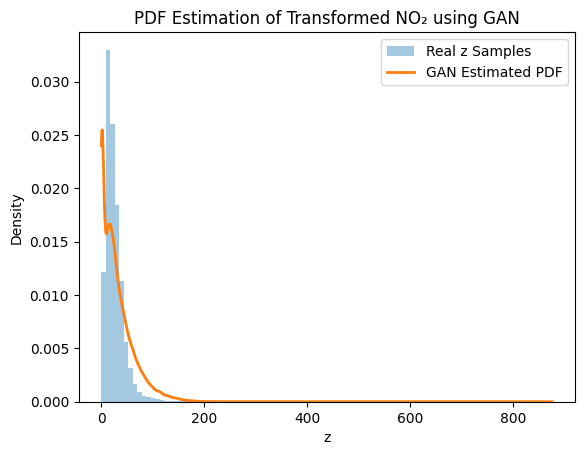

In [32]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(z_fake.flatten())
z_axis = np.linspace(z.min(), z.max(), 1000)
pdf_est = kde(z_axis)

plt.hist(z, bins=100, density=True, alpha=0.4, label="Real z Samples")
plt.plot(z_axis, pdf_est, label="GAN Estimated PDF", linewidth=2)
plt.xlabel("z")
plt.ylabel("Density")
plt.title("PDF Estimation of Transformed NO₂ using GAN")
plt.legend()
plt.show()
